# Tutorial 1

In [1]:
# load Python packages
import numpy as np  # for numerical pyhton libraries
import scipy.stats as st  # for statistical libraries
from scipy.special import gamma
import matplotlib.pyplot as plt  # for plotting

# import matplotlib.pylab as pylab
# params = {'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)

## Inverse Transform Method

Let $F(x)$ be a cumulative distribution function (CDF), and $U \sim  U(0,1)$. Then $F^{-1}(U)$ is distributed as $F$. Proof:
$$
   P(F^{-1}(U) < x) = P(U < F(x)) = F(x) = P(X < x)
$$

The algorithm is as follows: generate realizations of a uniform distribution and plug them in the inverse CDF.

#### Example 1: Exponential distribution

Recall that $F(x) = 1 - e^{-x/\lambda}$. In this example, we also use the fact that $1-U$ has the same uniform distribution as $U$.

In [2]:
def SimExp(a, nsims=10000):
    # generate uniform distribution
    U = np.random.uniform(0,1,nsims)
    
    # inverse transform
    Y = -a*np.log(U)
    
    # plot the distributions
    x = np.linspace(0,6,100)
    fig, axes = plt.subplots(figsize=(15,5))
    axes.hist(Y, bins=x, label='Histogram')
    axes.plot(x, nsims*np.exp(-x/a)/a*(x[1]-x[0]), linewidth=3, label='Exponential pdf')
    
    # aesthetics
    axes.set_xlim(-0.1, 6.0)
    axes.set_xlabel(r'$x$', fontsize=16)
    axes.set_ylabel(r'Freq.', fontsize=16)
    axes.set_title(r"Empirical vs theoretical pdf", fontsize=22)
    axes.tick_params(axis='both', labelsize=14)
    axes.legend(fontsize=16)
    plt.show()
    
    return Y

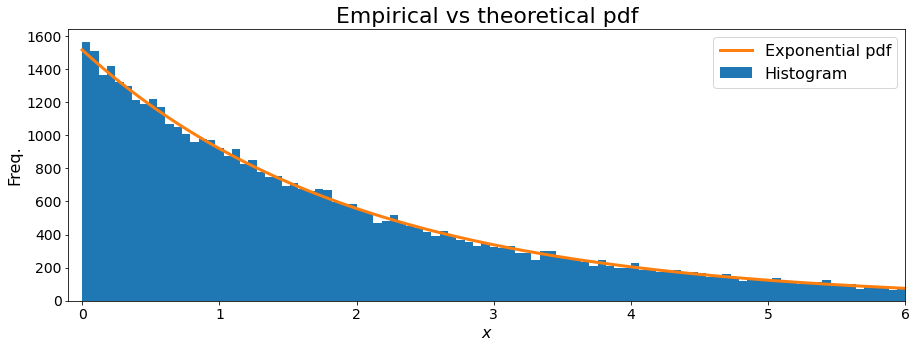

In [3]:
exp_dist = SimExp(2, 50000)

#### Example 2: Discrete distribution

Suppose you want to simulate a discrete random variable with $P(X = x_i) = \pi_i$.

In [4]:
def SimDiscrete(values, pis, nsims=10000):
    # generate uniform distribution
    U = np.random.uniform(0,1,nsims)
    cpis = np.cumsum(pis)
    Y = np.zeros(nsims)
    freq = np.zeros(len(values))
    prop = np.zeros((nsims,len(values)))
    
    # inverse transform
    for i in range(0,nsims):
        Y[i] = values[int(sum(U[i] > cpis))]
        freq[int(sum(U[i] > cpis))] += 1
        prop[i] = freq / (i+1)
        
    
    # plot the pis
    fig, axes = plt.subplots(figsize=(10,5))
    axes.bar(values, freq/nsims, width=0.4, align='center')
    
    # aesthetics
    axes.grid(color='gray', linestyle='--', linewidth=0.8, axis='y', alpha=0.7)
    axes.set_ylim(0.0, max(pis)+0.1)
    axes.set_xlabel(r"Values", fontsize=16)
    axes.set_ylabel(r"$\hat{\pi}_i$", fontsize=16)
    axes.set_title(r"Estimated $\pi_i$'s for each value", fontsize=22)
    axes.tick_params(axis='both', labelsize=14)
    plt.show()
    
    # plot the evolution
    fig, axes = plt.subplots(figsize=(10,5))
    axes.plot(range(0,nsims), prop)
    
    # aesthetics
    axes.set_xlim(0.0, nsims)
    axes.set_ylim(0.0, 0.8)
    axes.set_xlabel(r"Number of simulations", fontsize=16)
    axes.set_ylabel(r"$\hat{\pi}_i$", fontsize=16)
    axes.set_title(r"Evolution of $\hat{\pi}_i$ with number of simulations", fontsize=22)
    axes.tick_params(axis='both', labelsize=14)
    axes.legend(values, fontsize=16)
    plt.show()
    
    return Y

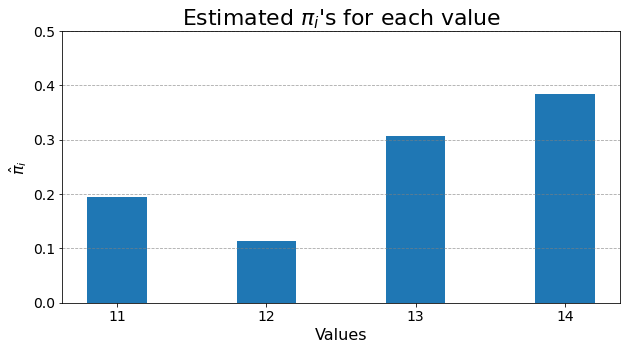

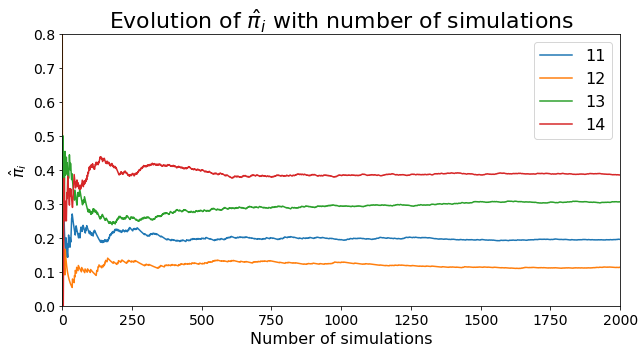

In [5]:
pis = np.array([0.2, 0.1, 0.3, 0.4])
values = np.array(['11', '12', '13', '14'])
disc_dist = SimDiscrete(values, pis, 2000)

## Acceptance-Rejection Method

Let $f(x)$ be a pdf, $g(x)$ be another pdf (instrumental distribution) and $c > 0$ such that
$$
\frac{f(x)}{g(x)} \leq c.
$$
Then we can generate realizations from $f$ with $g$ as an instrumental distribution using the following algorithm:

1. Find the constant $c$ that bounds the ratio, hopefully the smallest
2. Generate a realization $y$ from the instrumental dist. $g$
3. Generate a realization $u$ from a uniform distribution $U(0,1)$
4. IF $u \leq \frac{f(y)}{c g(y)}$, then $x = y$; otherwise repeat from Step 2

Indeed, we can show that
$$
P\Big(x \Bigm| U \leq \frac{f(y)}{c g(y)}\Big) = \frac{P\Big(U \leq \frac{f(y)}{c g(y)} \Bigm| x\Big) P(x)}{P\Big(U \leq \frac{f(y)}{c g(y)}\Big)} = \frac{P\Big(U \leq \frac{f(y)}{c g(y)} \Bigm| x\Big) P(x)}{\int_{x} P\Big(U \leq \frac{f(y)}{c g(y)} \Bigm| x\Big) P(x)} = f(x).
$$

---

How to find the optimal constant $c^{*}$?

1. Find the maximum of $\frac{f}{g}$ using derivatives
2. Verify it is a maximum with the second derivative
3. Plug the maximum in the function $\frac{f}{g}$

#### Example 3: Gamma distribution using the exponential instrumental distribution

In [6]:
def SimGamma(shape, scale, nsims=10000):
    a = scale*shape

    # constant c that bounds the ratio of densities (HOMEWORK)
    c = shape**(shape) / gamma(shape) * np.exp(-(shape-1))

    # initialize
    Y = np.zeros((nsims,1))
    counter = 0

    print('c =',c)

    # loop for all simulations
    for i in range(0,nsims):

        while True:
            # generate from the instrumental dist.
            y = -a*np.log(np.random.uniform())
            # compute the ratio of densities
            ratio = (1/c)*st.gamma.pdf(y,shape,0,scale)/(np.exp(-y/a)/a)
            counter += 1

            # stop if U < ratio
            if np.random.uniform() < ratio:
                break

        Y[i]=y
    
    print('Number of iterations =', counter)
    
    # plot the distributions
    x = np.linspace(0,6,100)
    fig, axes = plt.subplots(figsize=(15,5))
    axes.hist(Y, bins=x, label='Histogram')
    axes.plot(x, nsims*st.gamma.pdf(x, shape, 0, scale)*(x[1]-x[0]), linewidth=4, label='Gamma pdf')
    axes.plot(x, nsims*np.exp(-x/a)/a*(x[1]-x[0])*c, linewidth=4, label='Scaled exp. pdf')
    axes.set_xlim(0.0, 6.0)
    axes.set_xlabel(r'$x$', fontsize=16)
    axes.set_ylabel(r'Frequency', fontsize=16)
    axes.legend(fontsize=16)
    plt.show()
    
    return Y

c = 1.4715177646857693
Number of iterations = 29392


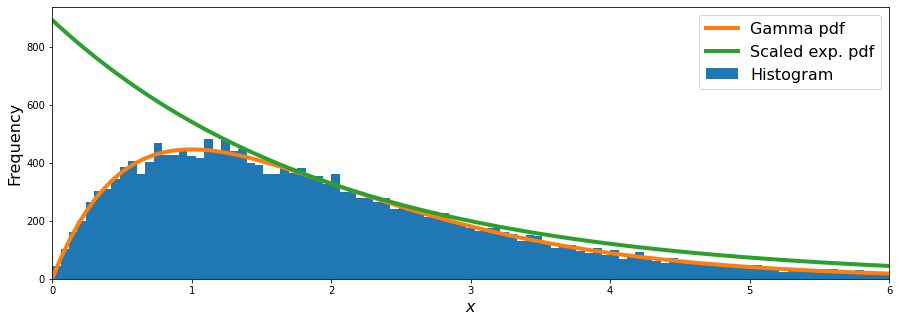

In [7]:
gamma_dist = SimGamma(2,1,20000)